# Installing necessary packages

In [ ]:
!pip install datasets>=1.18.3
!pip install transformers==4.17.0
!pip install seaborn

# Importing Libraries

In [ ]:
# Import libraries for system operations and data handling
import os
import json
import random
import numpy as np
import pandas as pd

# Import libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for audio processing and visualization
import torchaudio
import soundfile as sf
import IPython.display as ipd

# Import modules from Hugging Face's 'datasets' library for data loading and manipulation
from datasets import load_dataset, load_metric, Audio, Dataset

# Import modules from Hugging Face's 'transformers' library for speech recognition models and tokenizers
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, Wav2Vec2ForCTC
from tokenizers.processors import TemplateProcessing

# Import 'Levenshtein' for edit distance computation
import Levenshtein

# Import 'tqdm' for progress bars
from tqdm.auto import tqdm

# Import typing module for custom type annotations
from typing import Any, Dict, List, Optional, Union, Tuple

# Import 'torch' for working with tensors and gradients
import torch

import collections

# Helper Functions

In [ ]:
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#'
}

def reformat_data_dict(data_dictionary):
    """Segregate each feature from the data dictionary into separate arrays."""
    audio_file_list = []
    word_file_list = []
    phonetic_file_list = []

    for key, data_entry in data_dictionary.items():
        audio_file_list.append(data_entry['audio_file'])
        word_file_list.append(data_entry['word_file'])
        phonetic_file_list.append(data_entry['phonetic_file'])

    return {
        'audio_file': audio_file_list,
        'word_file': word_file_list,
        'phonetic_file': phonetic_file_list
    }

def read_and_concatenate_text(file_path):
    """Read text file and concatenate tokens into a single string."""
    with open(file_path) as file:
        tokens = [line.split()[-1] for line in file]
        return " ".join(tokens)

def update_dataset_entries(dataset_item):
    """Update each entry in the dataset with text and phonetic data read from corresponding files."""
    dataset_item['text'] = read_and_concatenate_text(dataset_item['word_file'])
    dataset_item['phonetic'] = read_and_concatenate_text(dataset_item['phonetic_file'])
    return dataset_item

def map_phoneme61_to_phoneme39(sentence):
    """Map each phoneme in the given sentence from TIMIT's set of 61 phonemes to a reduced set of 39 phonemes."""
    phoneme_tokens = [phon61_map39[phoneme] for phoneme in sentence.split()]
    return " ".join(phoneme_tokens)

def standardize_phonemes(dataset_item):
    """Standardize phoneme notation in the given dataset item."""
    dataset_item['phonetic'] = map_phoneme61_to_phoneme39(dataset_item['phonetic'])
    return dataset_item

def prepare_input_for_model(batch_data):
    """Prepare input for the Transformer model by resampling the audio data and converting the sentence into indices."""
    audio_data = batch_data["audio"]
    batch_data["input_values"] = processor(audio_data["array"], sampling_rate=audio_data["sampling_rate"]).input_values[0]
    batch_data["input_length"] = len(batch_data["input_values"])
    with processor.as_target_processor():
        batch_data["labels"] = processor(batch_data["phonetic"]).input_ids
    return batch_data

def get_train_test_df(dataset_path):
    df_train = pd.read_csv(os.path.join(dataset_path, 'train_data.csv'))
    df_test = pd.read_csv(os.path.join(dataset_path, 'test_data.csv'))
    df = pd.concat([df_train, df_test])
    df = df[df['is_converted_audio'] == False]

    return df_train, df_test, df

def process_and_split_data(df, data_path):
    data = {}

    for idx, row in tqdm(df.iterrows()):
        path = row['path_from_data_dir']
        entry_id = path.split('.')[0]

        if entry_id not in data:
            data[entry_id] = {}

        if row['is_audio'] is True:
            data[entry_id]['audio_file'] = os.path.join(data_path, path)
        elif row['is_word_file'] is True:
            data[entry_id]['word_file'] = os.path.join(data_path, path)
        elif row['is_phonetic_file'] is True:
            data[entry_id]['phonetic_file'] = os.path.join(data_path, path)

    keys = [key for key in data.keys() if len(data[key]) == 3]
    random.Random(101).shuffle(keys)

    num_train = int(len(keys) * 0.8)
    num_valid = int(len(keys) * 0.1)
    num_test = len(keys) - num_train - num_valid

    train_keys = keys[:num_train]
    valid_keys = keys[num_train:num_train + num_valid]
    test_keys = keys[-num_test:]

    train = {key: data[key] for key in train_keys}
    valid = {key: data[key] for key in valid_keys}
    test = {key: data[key] for key in test_keys}

    return train, valid, test

def preprocess_and_convert_to_chr(token_ids, tokenizer):
    """Function to preprocess token ids and convert to characters."""
    token_ids = preprocess_token_ids(token_ids)
    token_str = tokenizer.decode(token_ids, group_tokens=False)
    token_chr = "".join([chr(x) for x in token_ids])
    return token_chr, token_str

def evaluate_test_data(test_data):
    """Function to evaluate a single test_data."""
    # Extract the id of the test_data
    test_data_id = "/".join(test_data['audio']['path'].split('/')[5:])

    # Convert inputs and labels to tensors and move to GPU
    input_values = torch.Tensor(test_data['input_values']).unsqueeze(0).to('cuda')
    label_ids = torch.Tensor(test_data['labels']).unsqueeze(0).to('cuda')

    # Model inference
    with torch.no_grad():
        logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)

    # Convert ID to Char because Levenshtein library operates on char level
    predicted_chr, predicted_str = preprocess_and_convert_to_chr(predicted_ids[0].tolist(), tokenizer)
    label_chr, label_str = preprocess_and_convert_to_chr(label_ids[0].int().tolist(), tokenizer)

    # Compute PER (phoneme-error rate) and accuracy
    per_score = compute_per(predicted_chr, label_chr)
    accuracy = compute_accuracy(predicted_chr, label_chr)

    # Observe the operations like insertion, deletion, and substitution
    editops = Levenshtein.editops(predicted_chr, label_chr)
    editops = interpret_edit_operations(predicted_chr, label_chr, editops)

    return (test_data_id, predicted_str, label_str, editops, accuracy, per_score, len(label_chr))

def remove_duplicates(token_list):
    """Remove consecutive duplicate tokens from the given list."""
    previous_token = None
    unique_token_list = []

    for current_token in token_list:
        if current_token != previous_token and previous_token is not None:
            unique_token_list.append(previous_token)
        previous_token = current_token

    return unique_token_list

def preprocess_token_ids(token_id_list):
    """Remove padding and duplicate token_ids."""
    non_padding_token_ids = [token_id for token_id in token_id_list if token_id not in [PAD_ID, EMPTY_ID]]
    unique_token_ids = remove_duplicates(non_padding_token_ids)

    return unique_token_ids


def interpret_edit_operations(predicted_characters, label_characters, edit_operations):
    """Interpret the edit operations required to convert the predicted characters to the label characters."""
    interpreted_operation_list = []

    for operation in edit_operations:
        operation_type, predicted_index, label_index = operation

        if operation_type == "insert":
            label_token = tokenizer.decode(ord(label_characters[label_index]), group_tokens=False)
            interpreted_operation_list.append((operation_type, label_token, label_token))
        elif operation_type == "delete":
            predicted_token = tokenizer.decode(ord(predicted_characters[predicted_index]), group_tokens=False)
            interpreted_operation_list.append((operation_type, predicted_token, predicted_token))
        else:
            label_token = tokenizer.decode(ord(label_characters[label_index]), group_tokens=False)
            predicted_token = tokenizer.decode(ord(predicted_characters[predicted_index]), group_tokens=False)
            interpreted_operation_list.append((operation_type, predicted_token, label_token))

    return interpreted_operation_list

def compute_per(reference, hypothesis):
    """Compute Phone Error Rate (PER) by calculating Levenshtein distance between reference and hypothesis strings."""
    levenshtein_distance = Levenshtein.distance(reference, hypothesis)
    phone_error_rate = levenshtein_distance / len(reference)
    return phone_error_rate

def compute_accuracy(predicted_characters, label_characters):
    """Calculate accuracy by comparing predicted characters with label characters."""
    total_characters_count = len(label_characters)
    correct_characters_count = sum(
        1 for predicted_char, label_char in zip(predicted_characters, label_characters)
        if predicted_char == label_char
    )

    accuracy = correct_characters_count / total_characters_count

    return accuracy

def plot_distribution(metrics, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(metrics, bins=20, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_barplot(x_data, y_data, title, xlabel, ylabel, is_replacement=False):
    plt.figure(figsize=(15, 8))
    sns.barplot(x=x_data, y=y_data)
    plt.title(title, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    if is_replacement:
        # Rotate labels for readability
        plt.xticks(rotation=45, horizontalalignment='right')

    plt.show()

# Loading Dataset

In [ ]:
timit_path = '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/'
data_path = '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/'

In [ ]:
df_train, df_test, df = get_train_test_df(timit_path)

# Splitting the data

In [ ]:
train, valid, test = process_and_split_data(df, data_path)

0it [00:00, ?it/s]

# Preprocessing

## Transforming into HuggingFace data format

In [ ]:
train = reformat_data_dict(train)
valid = reformat_data_dict(valid)
test  = reformat_data_dict(test)

In [ ]:
train_dataset = Dataset.from_dict(train)
valid_dataset = Dataset.from_dict(valid)
test_dataset = Dataset.from_dict(test)

## Preparing Phoneme dataset

In [ ]:
train_dataset = (train_dataset
                 .map(update_dataset_entries)
                 .remove_columns(["word_file", "phonetic_file"]))
valid_dataset = (valid_dataset
                 .map(update_dataset_entries)
                 .remove_columns(["word_file", "phonetic_file"]))
test_dataset  = (test_dataset
                 .map(update_dataset_entries)
                 .remove_columns(["word_file", "phonetic_file"]))

  0%|          | 0/2688 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

## Standardization of Phonemes

In [ ]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
print("num of train phones:\t", len(set(train_phonetics)))

num of train phones:	 61


In [ ]:
train_dataset = train_dataset.map(standardize_phonemes)
valid_dataset = valid_dataset.map(standardize_phonemes)
test_dataset = test_dataset.map(standardize_phonemes)

  0%|          | 0/2688 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

In [ ]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
valid_phonetics = [phone for x in valid_dataset for phone in x['phonetic'].split()]
test_phonetics = [phone for x in test_dataset for phone in x['phonetic'].split()]

print("num of train phones:\t", len(set(train_phonetics)))
print("num of valid phones:\t", len(set(valid_phonetics)))
print("num of test phones:\t", len(set(test_phonetics)))

num of train phones:	 39
num of valid phones:	 39
num of test phones:	 39


## Checking a sample

In [ ]:
train_dataset = (train_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
valid_dataset = (valid_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
test_dataset = (test_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))

In [ ]:


rand_int = random.randint(0, len(train_dataset)-1)

print("Text:", train_dataset[rand_int]["text"])
print("Phonetics:", train_dataset[rand_int]["phonetic"])
print("Input array shape:", train_dataset[rand_int]["audio"]["array"].shape)
print("Sampling rate:", train_dataset[rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=train_dataset[rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: should she wake him
Phonetics: h# sh uh h# sh iy w ey h# k ih m h#
Input array shape: (39732,)
Sampling rate: 16000


## Building a vocabulary lookup dictionary

In [ ]:
vocab_train = list(set(train_phonetics)) + [' ']
vocab_valid = list(set(valid_phonetics)) + [' ']
vocab_test  = list(set(test_phonetics)) + [' ']

In [ ]:
vocab_list = list(set(vocab_train + vocab_valid + vocab_test))
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}

print(vocab_dict)

{' ': 0, 'aa': 1, 'ae': 2, 'ah': 3, 'aw': 4, 'ay': 5, 'b': 6, 'ch': 7, 'd': 8, 'dh': 9, 'dx': 10, 'eh': 11, 'er': 12, 'ey': 13, 'f': 14, 'g': 15, 'h#': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'ng': 25, 'ow': 26, 'oy': 27, 'p': 28, 'r': 29, 's': 30, 'sh': 31, 't': 32, 'th': 33, 'uh': 34, 'uw': 35, 'v': 36, 'w': 37, 'y': 38, 'z': 39}


In [ ]:
# make the space more intuitive to understand
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

42

In [ ]:

with open('/kaggle/working/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("/kaggle/working/", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|", )
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_dataset = train_dataset.map(prepare_input_for_model)
valid_dataset = valid_dataset.map(prepare_input_for_model)
test_dataset = test_dataset.map(prepare_input_for_model)

  0%|          | 0/2688 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?ex/s]

# Load the pretrained model that has been finetuned on TIMIT dataset

### https://huggingface.co/vitouphy/wav2vec2-xls-r-300m-timit-phoneme

In [ ]:
# load model and processor
#processor = Wav2Vec2Processor.from_pretrained("vitouphy/wav2vec2-xls-r-300m-phoneme")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model = Wav2Vec2ForCTC.from_pretrained("vitouphy/wav2vec2-xls-r-300m-timit-phoneme").to(device)
processor = Wav2Vec2Processor.from_pretrained("vitouphy/wav2vec2-xls-r-300m-timit-phoneme")


In [ ]:
PAD_ID = tokenizer.encode("[PAD]")[0]
EMPTY_ID = tokenizer.encode(" ")[0]

In [ ]:
result = []
for test_data in test_dataset:
    result.append(evaluate_test_data(test_data))


In [ ]:
result[0]

('TRAIN/DR3/MBEF0/SI1911.WAV',
 'h#tehnyiherzihh#gowdheyh#bluwahh#psahmahvaarh#dihh#chihs',
 'h#tehnyihrzihh#gowdheyh#bluwahh#psahmahvaarh#dihh#chihs',
 [('replace', 'er', 'r')],
 0.9714285714285714,
 0.02857142857142857,
 35)

In [ ]:
# Recalculate PER store for Test Set
total_per = 0
for entry in result:
    total_per += entry[-2]
print(f"Avg PER score: {total_per / len(result)}")

Avg PER score: 0.0730116868863158


In [ ]:
# Recalculate Generic Accuracy store for Test Set
total_generic_acc = 0
for entry in result:
    total_generic_acc += entry[-3]
print(f"Avg Generic Accuracy: {total_generic_acc / len(result)}")

Avg Generic Accuracy: 0.6255709821005389


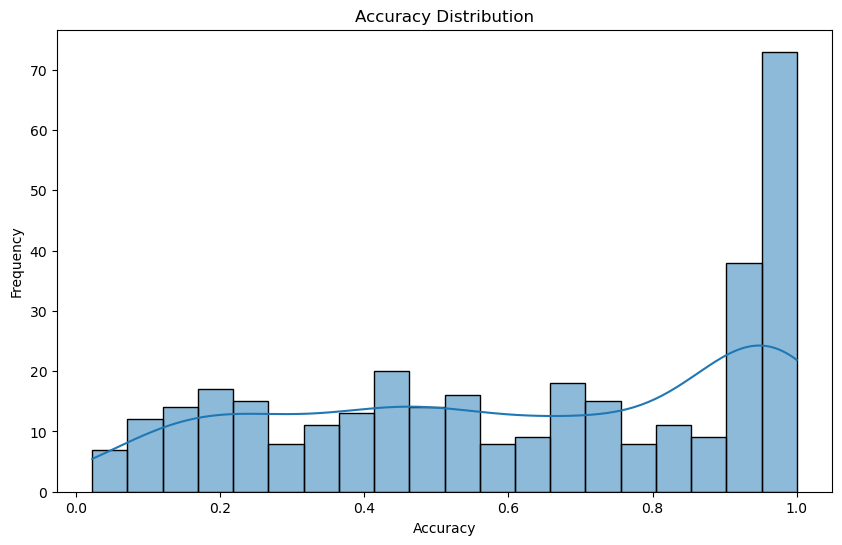

In [ ]:
accuracy_scores = [item[4] for item in result]
per_scores = [item[5] for item in result]
error_types = [item[3] for item in result]  # you need to preprocess this data further

# Accuracy distribution
plot_distribution(accuracy_scores, title='Accuracy Distribution', xlabel='Accuracy', ylabel='Frequency')

For most of the cases we achieve high accuracy.

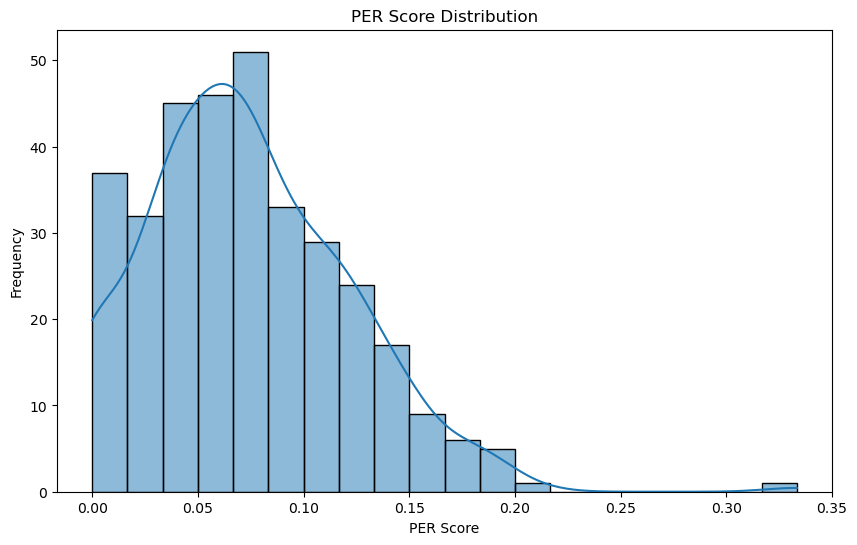

In [ ]:
# PER distribution
plot_distribution(per_scores, title='PER Score Distribution', xlabel='PER Score', ylabel='Frequency')

For most of the cases we achieve low PER, ~7%.

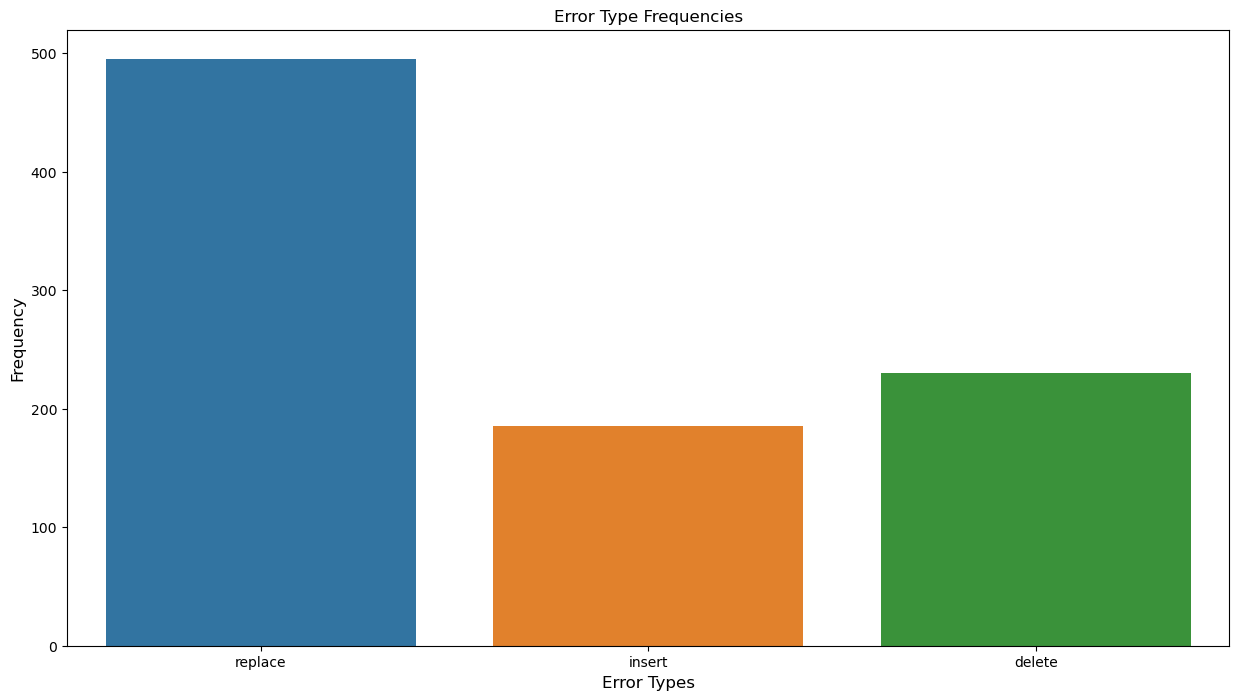

In [ ]:
# Flatten the list of error_types and get operation types
flat_error_types = [error[0] for sublist in error_types for error in sublist]

# Error types frequency
error_counts = dict(collections.Counter(flat_error_types))
plot_barplot(list(error_counts.keys()), list(error_counts.values()), 'Error Type Frequencies', 'Error Types', 'Frequency')

In [ ]:
insertions = []
deletions = []
replaces = []

for entry in result:
    editops = entry[3]
    for op, pred_token, label_token in editops:
        if op == "insert":
            insertions.append(label_token)
        elif op == "delete":
            deletions.append(pred_token)
        else:
            replaces.append((pred_token, label_token))

Calulating accuracy as per :W. -K. Leung, X. Liu and H. Meng, "CNN-RNN-CTC Based End-to-end Mispronunciation Detection and Diagnosis," ICASSP 2019 - 2019 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Brighton, UK, 2019, pp. 8132-8136, doi: 10.1109/ICASSP.2019.8682654. (https://ieeexplore.ieee.org/document/8682654)

In [ ]:
# Recalculate PR Accuracy for Test Set
total_labels = 0
for entry in result:
    total_labels += entry[-1]

pr_accuracy =(total_labels - len(insertions) - len(deletions) - len(replaces))/total_labels

print(f" PR Accuracy score: {pr_accuracy}")

 PR Accuracy score: 0.9262261856505878


In [ ]:
insert_freqs = {x: 0 for x in set(insertions)}
for insert_token in insertions:
    insert_freqs[insert_token] += 1

delete_freqs = {x: 0 for x in set(deletions)}
for delete_token in deletions:
    delete_freqs[delete_token] += 1

replace_freqs = {x: 0 for x in set(replaces)}
for replace_token in replaces:
    replace_freqs[replace_token] += 1

# Flatten the keys
replace_freqs_flat = {str(k): v for k, v in replace_freqs.items()}

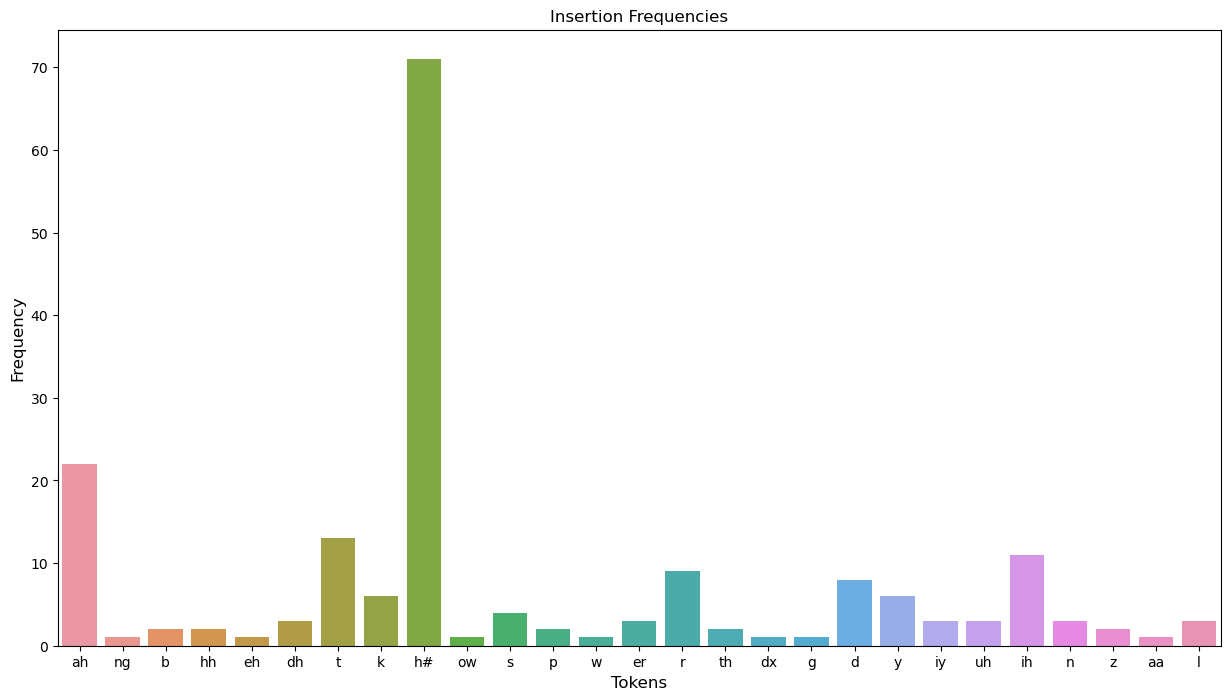

In [ ]:
# Insertion frequencies
plot_barplot(list(insert_freqs.keys()), list(insert_freqs.values()), 'Insertion Frequencies', 'Tokens', 'Frequency')

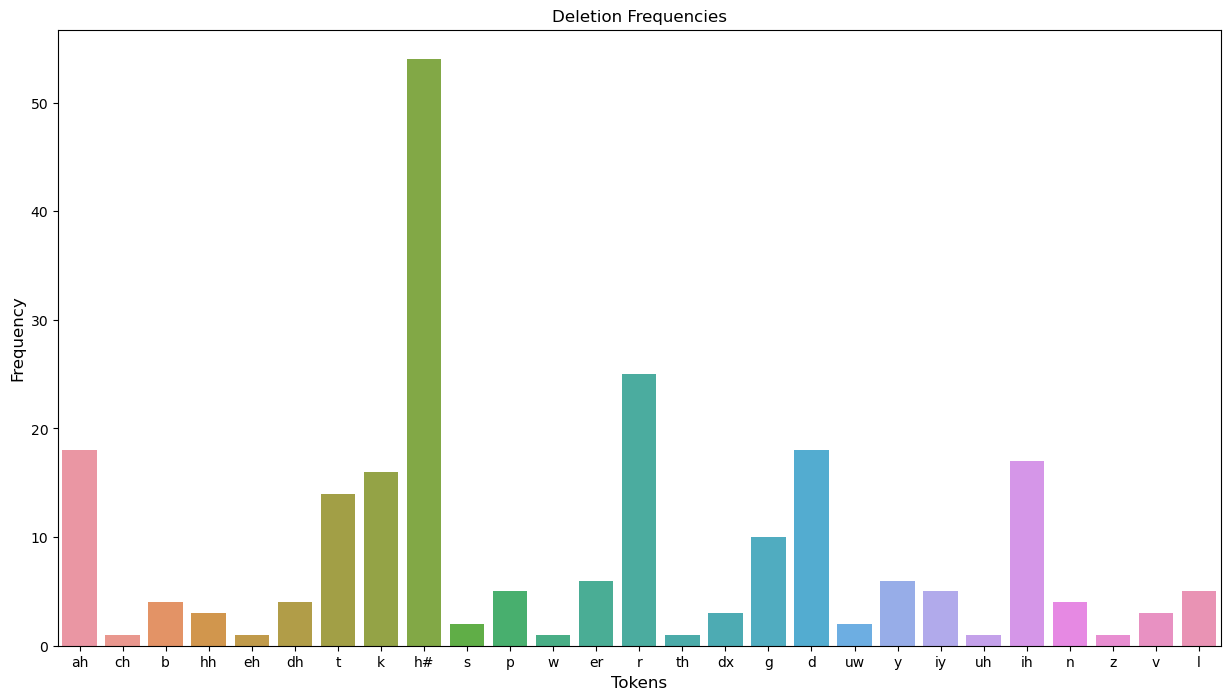

In [ ]:
# Deletion frequencies
plot_barplot(list(delete_freqs.keys()), list(delete_freqs.values()), 'Deletion Frequencies', 'Tokens', 'Frequency')

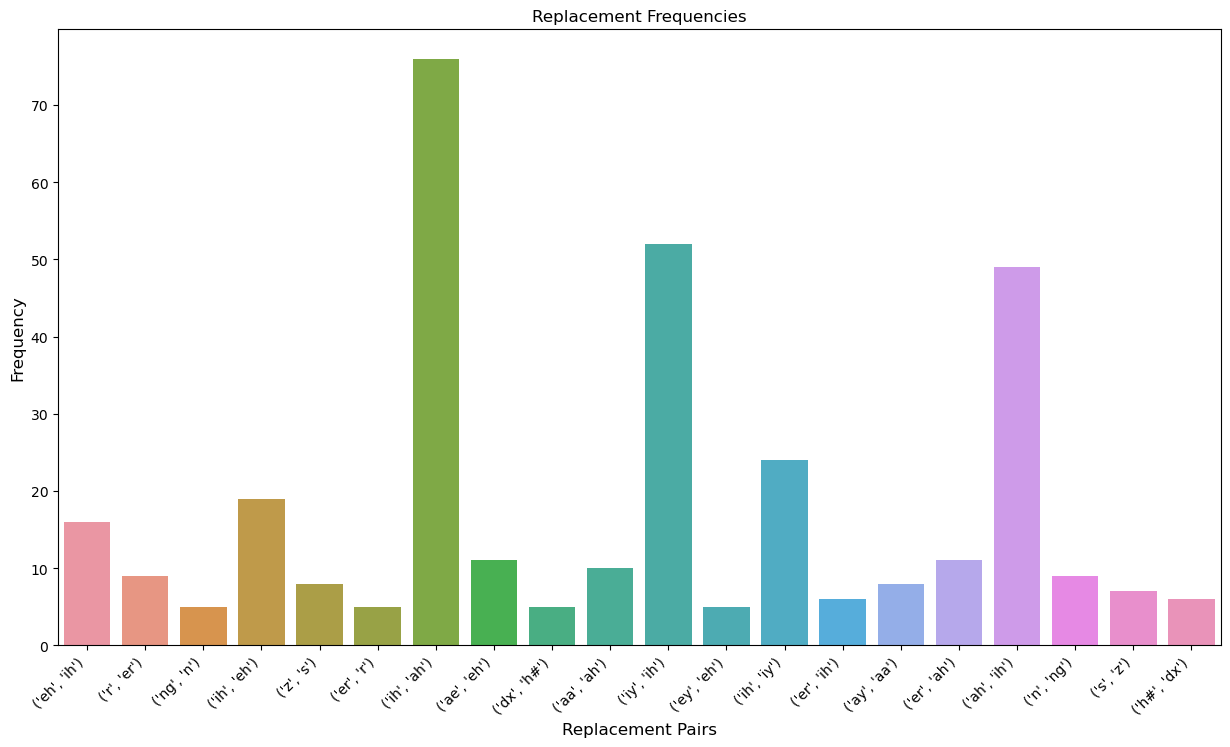

In [ ]:
# Filter replacements with frequency more than 10
filtered_replace_freqs = {k: v for k, v in replace_freqs_flat.items() if v > 4}

# Replacement frequencies
plot_barplot(list(filtered_replace_freqs.keys()), list(filtered_replace_freqs.values()), 'Replacement Frequencies', 'Replacement Pairs', 'Frequency', True)

In [ ]:
replace_freqs = {}
for replace in replaces:
    if replace not in replace_freqs:
        replace_freqs[replace] = 0
    replace_freqs[replace] += 1

In [ ]:
sorted_replace_freqs = sorted(replace_freqs.items(), key=lambda x: x[-1], reverse=True)
top_replace_freqs = list(filter(lambda x: x[-1] >= 5, sorted_replace_freqs))

In [ ]:
top_replace_freqs

[(('ih', 'ah'), 76),
 (('iy', 'ih'), 52),
 (('ah', 'ih'), 49),
 (('ih', 'iy'), 24),
 (('ih', 'eh'), 19),
 (('eh', 'ih'), 16),
 (('er', 'ah'), 11),
 (('ae', 'eh'), 11),
 (('aa', 'ah'), 10),
 (('r', 'er'), 9),
 (('n', 'ng'), 9),
 (('z', 's'), 8),
 (('ay', 'aa'), 8),
 (('s', 'z'), 7),
 (('er', 'ih'), 6),
 (('h#', 'dx'), 6),
 (('er', 'r'), 5),
 (('ey', 'eh'), 5),
 (('dx', 'h#'), 5),
 (('ng', 'n'), 5)]

In [ ]:
src = set([src_token for (src_token, dst_token), freq in top_replace_freqs])
dst = set([dst_token for (src_token, dst_token), freq in top_replace_freqs])

src_indices = {x: i for i, x in enumerate(sorted(src))}
dst_indices = {x: i for i, x in enumerate(sorted(dst))}

In [ ]:
matrix = [[0]*len(dst_indices) for _ in range(len(src_indices))]

for (src_token, dst_token), freq in top_replace_freqs:
    src_idx = src_indices[src_token]
    dst_idx = dst_indices[dst_token]
    matrix[src_idx][dst_idx] = freq

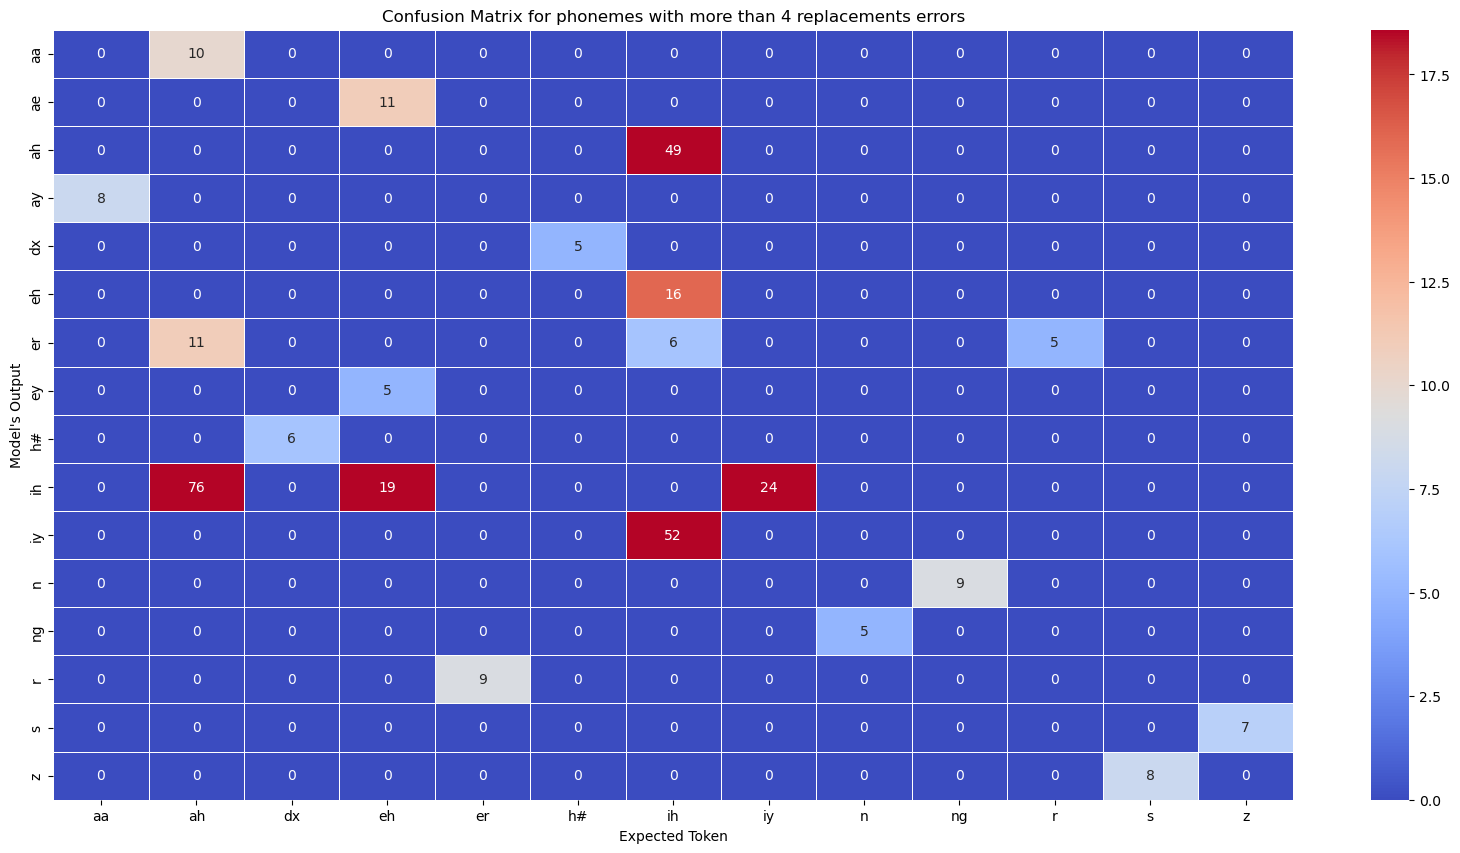

In [ ]:
# Set the figure size
fig, ax = plt.subplots(figsize=(20,10))

# Define colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Sort labels
xticklabels = sorted(dst)
yticklabels = sorted(src)

# Create the heatmap
sns.heatmap(
    matrix,
    linewidth=0.5,
    xticklabels=xticklabels,
    yticklabels=yticklabels,
    cmap=cmap,
    annot=True,
    robust=True,
    ax=ax
)

# Set the title
ax.set_title("Confusion Matrix for phonemes with more than 4 replacements errors")

# Set labels for the axes
ax.set_xlabel("Expected Token")
ax.set_ylabel("Model's Output")

# Display the plot
plt.show()

# **Analysis**

- The majority of errors in the phoneme recognition model were due to the replacement of one phoneme with another, especially phonemes with similar acoustic properties.
- The model struggled to distinguish subtle variations in vowel sounds, leading to confusion between phonemes like 'ih' and 'ah', 'iy' and 'ih', and 'ah' and 'ih'.
- Difficulties were observed in recognizing rhotic sounds and distinguishing between nasal consonants like 'n' and 'ng', indicating limitations in capturing specific phonetic characteristics that vary across accents.
- Challenges in recognizing voiced and voiceless fricatives were evident in the model's tendency to replace 'z' with 's', impacting the distinction between certain consonant sounds.
- The presence of the "h#" symbol as a sentence boundary marker caused insertions and deletions errors during phoneme recognition.